In [70]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)
from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

%matplotlib inline

In [71]:
# training params
batch_size = 64
num_epochs = 50
learning_rate = 0.01
dropout_p = 0.5
log_interval = 1 # epochs
num_hidden_units = 50
num_classes = 8
decay_rate = 0.9999
max_grad_norm = 5.0

# Use gpu
cuda = True
cuda = cuda and torch.cuda.is_available()

# reproduceability
seed = 42
torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

In [72]:
image_folder = 'data/'
data_transforms = transforms.Compose([
        transforms.CenterCrop(512),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.47637546, 0.485785  , 0.4522678 ], [0.24692202, 0.24377407, 0.2667196 ])
    ])
data = datasets.ImageFolder(root=image_folder, transform=data_transforms)
class_names = data.classes
train_len, val_len = int(len(data) * 0.5), int(len(data) * 0.25)
test_len = len(data) - train_len - val_len
train_set, val_set, test_set = torch.utils.data.random_split(data, [train_len, val_len, test_len])
loader = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4),
    'test': torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
}

In [53]:
len(class_names)

8

In [25]:
#x=0
mean, std = [], []
for i, da in enumerate(loader['train']):
    #print(i, da)
    #print(da[0].numpy().shape)
    #print(len(da))
    #print(da[1].shape)
    mean.append(np.mean(da[0].numpy(), axis=(0, 2, 3)))
    std.append(np.std(da[0].numpy(), axis=(0, 2, 3)))
    #x += 1
#print(i, x)

In [28]:
mean

[array([0.4576749 , 0.46450436, 0.42260045], dtype=float32),
 array([0.4898176 , 0.4978957 , 0.46054214], dtype=float32),
 array([0.4834872 , 0.48373422, 0.44564795], dtype=float32),
 array([0.47223726, 0.47781587, 0.44281587], dtype=float32),
 array([0.49982673, 0.5016742 , 0.46665508], dtype=float32),
 array([0.48113465, 0.48872072, 0.46047452], dtype=float32),
 array([0.46553686, 0.47689274, 0.43644017], dtype=float32),
 array([0.45924532, 0.4655936 , 0.4354285 ], dtype=float32),
 array([0.49174395, 0.49717593, 0.44567782], dtype=float32),
 array([0.44912076, 0.48696375, 0.46096012], dtype=float32),
 array([0.4653755 , 0.4839147 , 0.45142123], dtype=float32),
 array([0.46989724, 0.48098373, 0.4717807 ], dtype=float32),
 array([0.50778294, 0.50933564, 0.47903663], dtype=float32)]

In [29]:
np.mean(mean, axis=0)

array([0.47637546, 0.485785  , 0.4522678 ], dtype=float32)

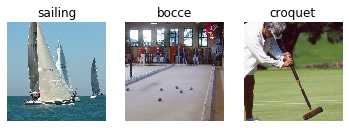

In [73]:
batch = next(iter(loader['train']))
samples = batch[0][:3]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 3, i+1)
    plt.title(f'{class_names[y_true[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

In [ ]:
# CNN model
class CNN(nn.Module):
    """
    Simple CNN for MNIST classification.
    """
    def __init__(self, dropout_p, num_hidden_units, num_classes):
        """
        Initialization.
        """
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 30, kernel_size=5)
        self.conv3 = nn.Conv2d(30, 40, kernel_size=5)
        self.conv4 = nn.Conv2d(40, 20, kernel_size=3)
        self.dropout_conv2 = nn.Dropout2d(dropout_p)
        self.fc1 = nn.Linear(20 * 2 * 2, num_hidden_units)
        self.fc2 = nn.Linear(num_hidden_units, num_classes)

    def forward(self, x):
        """
        Feed Foward.
        """
        
        x = F.relu(F.max_pool2d(self.conv1(x), 3))
        x = F.relu(F.max_pool2d(self.dropout_conv2(self.conv2(x)), 3))
        x = F.relu(F.max_pool2d(self.conv3(x), 5))
        x = F.relu(F.max_pool2d(self.conv4(x), 4))
        x = x.view(-1, 20*2*2)  # flatten
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x  # logits

In [ ]:
# Initialize model components
model = CNN(dropout_p, num_hidden_units, num_classes)
if cuda:
    model.cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
def process_batch(inputs, targets, model, criterion, optimizer, cuda, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    if cuda:
        inputs, targets = inputs.cuda(), targets.cuda()
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, volatile=True, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [92]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda):
    """
    Training.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)
            #print(loss.data.item())
            # Add to batch scalars
            train_batch_loss += loss.data.item() / float(len(inputs))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(inputs, target, model, criterion, optimizer, cuda, model.training)
                # Add to batch scalars
                test_batch_loss += loss.data.item() / float(len(inputs))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                

            verbose_condition = \
                (num_train_epoch == 0) or (num_train_epoch % log_interval == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print("TIME REMAINING: %im %is" % (minutes, seconds))
                print("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
    
    return model

In [93]:
model = train(model, criterion, optimizer, loader['train'], loader['val'], 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm, cuda)

OSError: [Errno 12] Cannot allocate memory